In [1]:
import os
import pandas as pd
import upsetplot
from functools import reduce
from itertools import combinations

# plotting modules
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 5, 'ytick.major.width': 1.5, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
groups = ["british_male", "british_female", "pre_menopause", "post_menopause"]

gene_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/british_male/genes.list",
    "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/british_female/genes.list",
    "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/pre_menopause/genes.list",
    "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/post_menopause/genes.list",
    ]

go_enrich_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/british_male/GO_Biological_Process_2023_enrich.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/british_female/GO_Biological_Process_2023_enrich.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/pre_menopause/GO_Biological_Process_2023_enrich.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/post_menopause/GO_Biological_Process_2023_enrich.csv"
]

kegg_enrich_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/british_male/KEGG_2021_Human_enrich.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/british_female/KEGG_2021_Human_enrich.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/pre_menopause/KEGG_2021_Human_enrich.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/enrichment/post_menopause/KEGG_2021_Human_enrich.csv"
]

In [3]:
def read_genes(gene_file):
    with open(gene_file, "r") as f:
        genes = set([g.strip() for g in f.readlines()])
    return genes

def set_add(a, b):
    return a.intersection(b)

def set_subtract(a,b):
    return a.difference(b)

def get_intersects(include_sets, exclude_sets):
    intersect_sets = reduce(set_add, include_sets)
    if len(exclude_sets)>0:
        exclude_sets = [intersect_sets] + exclude_sets
        intersect_sets = reduce(set_subtract, exclude_sets)
    return intersect_sets

def get_upset_df(group_sets, groups):
    # get the set of items for each group
    item_dict = {g: s for g,s in zip(groups, group_sets)}
    item_boolean_dict = {g:[] for g in groups}
    counts = []
    unique_intersect_sets = dict()
    for i in range(1, len(groups) + 1):
        # get combinations of length i
        all_items = list(combinations(groups, i))
        for items in all_items:
            # get counts of elements that are unique to the group
            include_items = items
            exclude_items = tuple(g for g in groups if g not in include_items)
            include_sets = [item_dict[c] for c in include_items]
            exclude_sets = [item_dict[c] for c in exclude_items]
            unique_intersects = get_intersects(include_sets, exclude_sets)
            counts.append(len(unique_intersects))
            unique_intersect_sets[(include_items, exclude_items)] = unique_intersects
            for c in include_items:
                item_boolean_dict[c].append(True)
            for c in exclude_items:
                item_boolean_dict[c].append(False)
    item_boolean_dict["counts"] = counts
    df = pd.DataFrame(item_boolean_dict)
    return df.set_index(groups), unique_intersect_sets

# Genes

In [4]:
group_genes = list(map(read_genes, gene_files))

In [5]:
gene_upset_df, gene_unique_intersects = get_upset_df(group_genes, groups)

/data6/deepro/miniconda3/envs/dnanexus/lib/python3.11/site-packages/upsetplot/plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['black' '#0000002e' '#0000002e' '#0000002e' '#0000002e' 'black'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' 'black' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' 'black' 'black' 'black' '#0000002e'
 '#0000002e' 'black' '#0000002e' 'black' '#0000002e' '#0000002e' 'black'
 'black' '#0000002e' 'black' '#0000002e' '#0000002e' 'black' '#0000002e'
 'black' '#0000002e' 'black' '#0000002e' '#0000002e' 'black' 'black'
 'black' 'black' 'black' '#0000002e' 'black' 'black' '#0000002e' 'black'
 'black' '#0000002e' 'black' 'black' '#0000002e' 'black' 'black' 'black'
 'black' 'black' 'black' 'black']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["edgecolor"].fillna(styles["facecolor"], inplace=True)
/data6/deepro/miniconda3/envs/d

(0.0, 1.0, 0.0, 1.0)

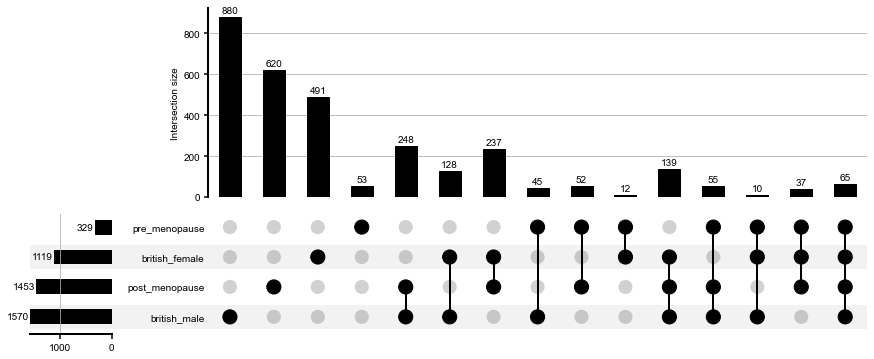

In [6]:
parsed_gene_upset_df = gene_upset_df.loc[gene_upset_df.counts>0]
fig,ax = plt.subplots(1,1, figsize=(15, 6))
upsetplot.plot(parsed_gene_upset_df.counts, show_counts=True, fig=fig, element_size=None)
ax.axis("off")

# GO terms

In [7]:
def read_enrich_files(filename):
    df = pd.read_csv(filename)
    df = df.loc[df.adj_pval<0.05]
    return set(df["Term"])

In [8]:
group_gos = list(map(read_enrich_files, go_enrich_files))

/data6/deepro/miniconda3/envs/dnanexus/lib/python3.11/site-packages/upsetplot/plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['black' '#0000002e' '#0000002e' '#0000002e' '#0000002e' 'black'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' 'black' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' 'black' 'black' 'black' '#0000002e'
 '#0000002e' 'black' '#0000002e' 'black' '#0000002e' '#0000002e' 'black'
 'black' '#0000002e' 'black' '#0000002e' '#0000002e' 'black' '#0000002e'
 'black' '#0000002e' 'black' '#0000002e' '#0000002e' 'black' 'black'
 'black' 'black' 'black' '#0000002e' 'black' 'black' '#0000002e' 'black'
 'black' '#0000002e' 'black' 'black' 'black' 'black' 'black' 'black']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["edgecolor"].fillna(styles["facecolor"], inplace=True)
/data6/deepro/miniconda3/envs/dnanexus/lib/python3.11/site-packages/

(0.0, 1.0, 0.0, 1.0)

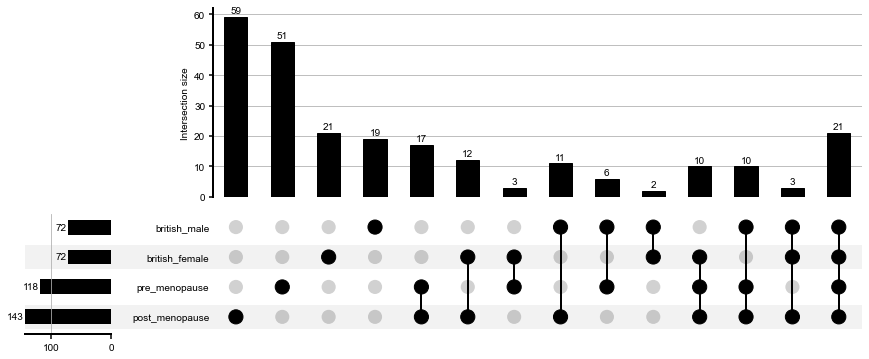

In [9]:
go_upset_df, go_unique_intersects = get_upset_df(group_gos, groups)
parsed_go_upset_df = go_upset_df.loc[go_upset_df.counts>0]
fig,ax = plt.subplots(1,1, figsize=(15, 6))
upsetplot.plot(parsed_go_upset_df.counts, show_counts=True, fig=fig, element_size=None)
ax.axis("off")

In [10]:
go_unique_intersects[(('british_male', 'british_female',
   'pre_menopause',
   'post_menopause'), ())]

{'Actin Filament-Based Transport (GO:0099515)',
 'Actomyosin Structure Organization (GO:0031032)',
 'Calcium Ion Import Across Plasma Membrane (GO:0098703)',
 'Calcium Ion Transmembrane Import Into Cytosol (GO:0097553)',
 'External Encapsulating Structure Organization (GO:0045229)',
 'Extracellular Matrix Organization (GO:0030198)',
 'Extracellular Structure Organization (GO:0043062)',
 'Inorganic Cation Import Across Plasma Membrane (GO:0098659)',
 'Inorganic Cation Transmembrane Transport (GO:0098662)',
 'Monoatomic Cation Transmembrane Transport (GO:0098655)',
 'Muscle Contraction (GO:0006936)',
 'Organic Substance Transport (GO:0071702)',
 'Sensory Perception Of Mechanical Stimulus (GO:0050954)',
 'Sensory Perception Of Sound (GO:0007605)',
 'Sodium Ion Transmembrane Transport (GO:0035725)',
 'Sodium Ion Transport (GO:0006814)',
 'Striated Muscle Contraction (GO:0006941)',
 'Supramolecular Fiber Organization (GO:0097435)',
 'Transport Across Blood-Brain Barrier (GO:0150104)',
 'Vas

# KEGG terms

In [11]:
group_keggs = list(map(read_enrich_files, kegg_enrich_files))

/data6/deepro/miniconda3/envs/dnanexus/lib/python3.11/site-packages/upsetplot/plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['black' '#0000002e' '#0000002e' '#0000002e' '#0000002e' 'black'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' 'black' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' 'black' 'black' 'black' '#0000002e'
 '#0000002e' 'black' '#0000002e' 'black' '#0000002e' '#0000002e' 'black'
 'black' '#0000002e' 'black' '#0000002e' '#0000002e' 'black' 'black'
 'black' 'black' '#0000002e' 'black' 'black' '#0000002e' 'black' 'black'
 '#0000002e' 'black' 'black' 'black' 'black' 'black' 'black']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["edgecolor"].fillna(styles["facecolor"], inplace=True)
/data6/deepro/miniconda3/envs/dnanexus/lib/python3.11/site-packages/upsetplot/plotting.py:663: FutureWarning: Setting an item of incompatible dtype i

(0.0, 1.0, 0.0, 1.0)

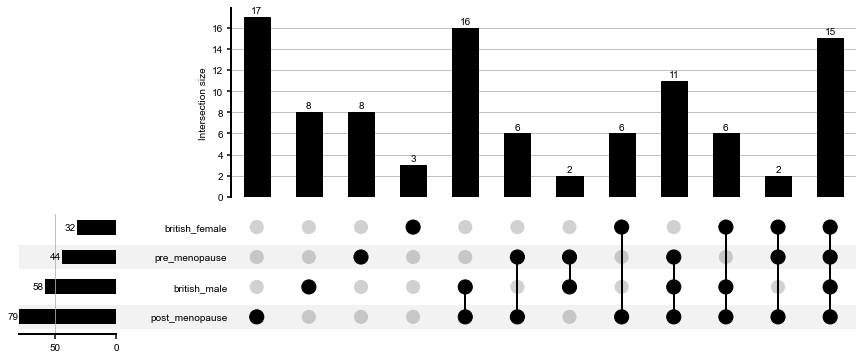

In [12]:
kegg_upset_df, kegg_unique_intersects = get_upset_df(group_keggs, groups)
parsed_kegg_upset_df = kegg_upset_df.loc[kegg_upset_df.counts>0]
fig,ax = plt.subplots(1,1, figsize=(15, 6))
upsetplot.plot(parsed_kegg_upset_df.counts, show_counts=True, fig=fig, element_size=None)
ax.axis("off")

In [13]:
kegg_unique_intersects[(('british_male', 'british_female',
   'pre_menopause',
   'post_menopause'), ())]

{'ABC transporters',
 'Aldosterone synthesis and secretion',
 'Arrhythmogenic right ventricular cardiomyopathy',
 'Ascorbate and aldarate metabolism',
 'Bile secretion',
 'Carbohydrate digestion and absorption',
 'Dilated cardiomyopathy',
 'Fructose and mannose metabolism',
 'Hypertrophic cardiomyopathy',
 'Pancreatic secretion',
 'Pentose and glucuronate interconversions',
 'Porphyrin and chlorophyll metabolism',
 'Protein digestion and absorption',
 'Starch and sucrose metabolism',
 'Thyroid hormone synthesis'}

In [14]:
kegg_unique_intersects.keys()

dict_keys([(('british_male',), ('british_female', 'pre_menopause', 'post_menopause')), (('british_female',), ('british_male', 'pre_menopause', 'post_menopause')), (('pre_menopause',), ('british_male', 'british_female', 'post_menopause')), (('post_menopause',), ('british_male', 'british_female', 'pre_menopause')), (('british_male', 'british_female'), ('pre_menopause', 'post_menopause')), (('british_male', 'pre_menopause'), ('british_female', 'post_menopause')), (('british_male', 'post_menopause'), ('british_female', 'pre_menopause')), (('british_female', 'pre_menopause'), ('british_male', 'post_menopause')), (('british_female', 'post_menopause'), ('british_male', 'pre_menopause')), (('pre_menopause', 'post_menopause'), ('british_male', 'british_female')), (('british_male', 'british_female', 'pre_menopause'), ('post_menopause',)), (('british_male', 'british_female', 'post_menopause'), ('pre_menopause',)), (('british_male', 'pre_menopause', 'post_menopause'), ('british_female',)), (('brit

In [15]:
kegg_unique_intersects[(('british_female',), ('british_male','pre_menopause', 'post_menopause'))]

{'Cardiac muscle contraction',
 'TGF-beta signaling pathway',
 'Tryptophan metabolism'}

In [16]:
kegg_unique_intersects[(('british_male',), ('british_female', 'pre_menopause', 'post_menopause'))]

{'Arginine and proline metabolism',
 'Cellular senescence',
 'Glycine serine and threonine metabolism',
 'Histidine metabolism',
 'Pantothenate and CoA biosynthesis',
 'Selenocompound metabolism',
 'Staphylococcus aureus infection',
 'Synaptic vesicle cycle'}

In [17]:
kegg_unique_intersects[(('pre_menopause',), ('british_male', 'british_female', 'post_menopause'))]

{'AGE-RAGE signaling pathway in diabetic complications',
 'Endocrine and other factor-regulated calcium reabsorption',
 'Mismatch repair',
 'Pathways in cancer',
 'Phagosome',
 'Small cell lung cancer',
 'Taste transduction',
 'Vitamin digestion and absorption'}

In [18]:
kegg_unique_intersects[(('post_menopause',), ('british_male', 'british_female', 'pre_menopause'))]

{'AMPK signaling pathway',
 'Citrate cycle (TCA cycle)',
 'Growth hormone synthesis secretion and action',
 'Inositol phosphate metabolism',
 'Insulin resistance',
 'Insulin signaling pathway',
 'Malaria',
 'Melanogenesis',
 'MicroRNAs in cancer',
 'Pathogenic Escherichia coli infection',
 'Pentose phosphate pathway',
 'Phenylalanine metabolism',
 'Platelet activation',
 'Proteoglycans in cancer',
 'Regulation of actin cytoskeleton',
 'Tyrosine metabolism',
 'Vascular smooth muscle contraction'}

# KEGG unique intersect genes

## Female

In [19]:
kegg_female_df = pd.read_csv(kegg_enrich_files[1])

In [20]:
def get_unique_genes_from_terms(enrich_df, term_unique_intersects, gene_unique_intersects, ut_key):
    unique_terms = term_unique_intersects[ut_key]
    enrich_df = enrich_df.loc[enrich_df.Term.isin(unique_terms)]
    unique_genes = gene_unique_intersects[ut_key]
    enrich_df["genes"] = enrich_df.genes.apply(lambda x: "|".join(set(x.split("|")).intersection(unique_genes)))
    return enrich_df
    

In [21]:
get_unique_genes_from_terms(kegg_female_df, kegg_unique_intersects, gene_unique_intersects, (('british_female',), ('british_male','pre_menopause', 'post_menopause')))

/tmp/ipykernel_8774/3387058214.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enrich_df["genes"] = enrich_df.genes.apply(lambda x: "|".join(set(x.split("|")).intersection(unique_genes)))


,Term,p_val,adj_pval,odds_ratio,combined_score,genes
19,Cardiac muscle contraction,0.001317,0.019750,2.921390,19.376506,CASQ2|ATP1A3|ATP2A2|ATP1A2
26,Tryptophan metabolism,0.003178,0.035311,3.692275,21.236170,ALDH3A2|TPH1|TDO2|MAOB
27,TGF-beta signaling pathway,0.003714,0.038171,2.554747,14.295459,CHRD|AMHR2|BMPR1B|TGFBR1|FBN1|GDF6|INHBC


## Male

In [22]:
kegg_male_df = pd.read_csv(kegg_enrich_files[0])
kegg_male_df = get_unique_genes_from_terms(kegg_male_df, kegg_unique_intersects, gene_unique_intersects, (('british_male',), ('british_female','pre_menopause', 'post_menopause')))

/tmp/ipykernel_8774/3387058214.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enrich_df["genes"] = enrich_df.genes.apply(lambda x: "|".join(set(x.split("|")).intersection(unique_genes)))


In [23]:
kegg_male_df

,Term,p_val,adj_pval,odds_ratio,combined_score,genes
15,Staphylococcus aureus infection,0.000113,0.002217,3.008924,27.337308,MASP2|C2|KRT24|KRT14|C1QC|KRT32|KRT25|SELP|KRT...
22,Pantothenate and CoA biosynthesis,0.000876,0.010715,5.857965,41.238463,PANK1|BCAT2|DPYS|GADL1|ENPP3
35,Selenocompound metabolism,0.001969,0.017000,5.930946,36.951334,TXNRD1|TXNRD3|MARS1|PAPSS1
36,Synaptic vesicle cycle,0.002010,0.017000,2.595927,16.120227,DNM1|ATP6V0A2|ATP6V1C2|SLC6A9|SLC6A5|SLC6A7|AT...
37,Cellular senescence,0.002281,0.018788,2.032311,12.362850,TSC1|HLA-C|MAP2K2|TGFB1|RAD50|NFATC1|RAD1|TP53...
45,Glycine serine and threonine metabolism,0.004429,0.030139,3.264638,17.692690,DAO|CHDH|PGAM2|AOC2
54,Arginine and proline metabolism,0.008105,0.045218,2.720673,13.100905,P4HA1|AGMAT|CNDP1|NOS1|ALDH4A1|DAO|P4HA2
56,Histidine metabolism,0.008235,0.045218,4.076327,19.563965,CNDP1|ASPA


In [24]:
kegg_male_df.iloc[3].genes

'DNM1|ATP6V0A2|ATP6V1C2|SLC6A9|SLC6A5|SLC6A7|ATP6V1H|RIMS1|ATP6V1A|SLC17A8'

## Pre-menopausal

In [25]:
kegg_prem_df = pd.read_csv(kegg_enrich_files[2])
get_unique_genes_from_terms(kegg_prem_df, kegg_unique_intersects, gene_unique_intersects, (('pre_menopause',), ('british_male', 'british_female', 'post_menopause')))

/tmp/ipykernel_8774/3387058214.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enrich_df["genes"] = enrich_df.genes.apply(lambda x: "|".join(set(x.split("|")).intersection(unique_genes)))


,Term,p_val,adj_pval,odds_ratio,combined_score,genes
19,Pathways in cancer,0.000421,0.004844,2.421545,18.821218,AXIN1|FZD10|PLD2|PLCB2
20,Taste transduction,0.000774,0.008473,5.066890,36.301137,PLCB2
30,Endocrine and other factor-regulated calcium r...,0.002413,0.017899,5.854552,35.285844,PLCB2
37,Phagosome,0.004522,0.027372,3.272383,17.666748,
40,Small cell lung cancer,0.005860,0.032874,3.925121,20.173480,
41,Mismatch repair,0.007485,0.040989,8.391718,41.076320,
42,Vitamin digestion and absorption,0.008444,0.045164,7.991674,38.154997,
43,AGE-RAGE signaling pathway in diabetic complic...,0.008718,0.045569,3.589487,17.022861,PLCB2


# Post menopausal

In [26]:
kegg_post_df = pd.read_csv(kegg_enrich_files[3])
pm_df = get_unique_genes_from_terms(kegg_post_df, kegg_unique_intersects, gene_unique_intersects, (('post_menopause',), ('british_male', 'british_female', 'pre_menopause')))

/tmp/ipykernel_8774/3387058214.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enrich_df["genes"] = enrich_df.genes.apply(lambda x: "|".join(set(x.split("|")).intersection(unique_genes)))


In [27]:
pm_df

,Term,p_val,adj_pval,odds_ratio,combined_score,genes
20,Pentose phosphate pathway,0.000058,0.000857,5.930007,57.843527,GPI|FBP2|PGM1|PFKL|PFKP
23,Regulation of actin cytoskeleton,0.000143,0.001845,2.164588,19.162362,PAK6|PDGFRA|GNA13|PPP1CC|EZR|ACTN4|PAK4|APC2|I...
24,Insulin signaling pathway,0.000149,0.001845,2.529797,22.295616,PRKAR1B|HKDC1|GYS2|FBP2|PYGL|PHKG1|PDE3B|PPP1C...
33,AMPK signaling pathway,0.000381,0.003477,2.523383,19.863784,CREB3L3|CD36|GYS2|FBP2|MTOR|INSR|PFKL|IGF1R|ML...
38,MicroRNAs in cancer,0.000667,0.005299,2.204456,16.121561,SERPINB5|PDGFRA|DNMT1|CYP1B1|EZR|MTOR|PAK4|APC...
42,Inositol phosphate metabolism,0.001391,0.009822,2.815632,18.520171,PI4K2B|INPP5J|SYNJ1|INPP5K|MTMR8
46,Insulin resistance,0.001722,0.011358,2.375470,15.118200,CREB3L3|GYS2|CD36|PYGL|PPP1CC|MTOR|INSR|NOS3
48,Proteoglycans in cancer,0.002020,0.012693,1.926409,11.952235,WNT16|WNT2|FZD2|WNT10A|ITPR3|MTOR|PPP1CC|EZR|R...
49,Melanogenesis,0.002047,0.012693,2.402921,14.877008,ADCY8|WNT16|WNT2|CREB3L3|FZD2|WNT10A|LEF1|TYRP...
50,Growth hormone synthesis secretion and action,0.002176,0.013226,2.256946,13.835870,GHSR|CREB3L3|ADCY8|GHR|ITPR3|MTOR|ITPR1|ADCY1


In [28]:
pm_df.iloc[3].genes

'CREB3L3|CD36|GYS2|FBP2|MTOR|INSR|PFKL|IGF1R|MLYCD|PFKP'